# Exercise 6 - Pixel classification and object segmentation

In [4]:
# import relevant packages 
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

### Explorative Analysis of one CT scan 

In [5]:
in_dir = "data_ex6/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


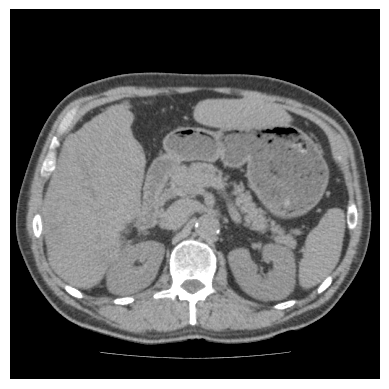

In [6]:
# Exercise 1
plt.figure()
plt.imshow(img, vmin=-200, vmax=200, cmap='gray')
plt.axis('off')
io.show()

In [7]:
# Exercise 2 
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

print(f"The mean spleen HU is given by {mu_spleen:.2f} with corresponding standard deviation {std_spleen:.2f}")

The mean spleen HU is given by 49.48 with corresponding standard deviation 15.00


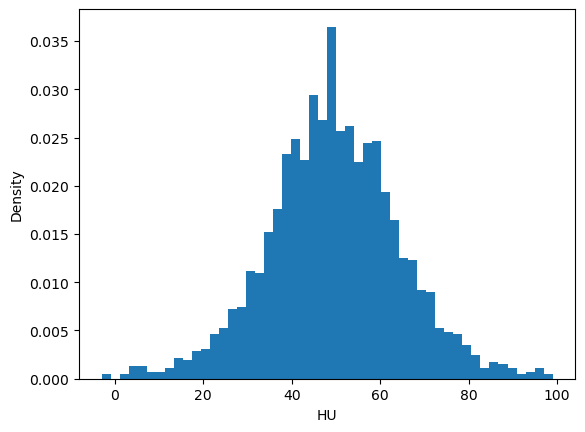

In [8]:
# Exercise 3
plt.figure()
plt.hist(spleen_values.ravel(), bins = 50, density = True)
plt.ylabel("Density")
plt.xlabel("HU")
plt.title("")
plt.show()

C:\Users\There\AppData\Local\Temp\ipykernel_2096\2221399962.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([spleen_values, kidney_values, fat_values, bone_values, background_values, liver_values])


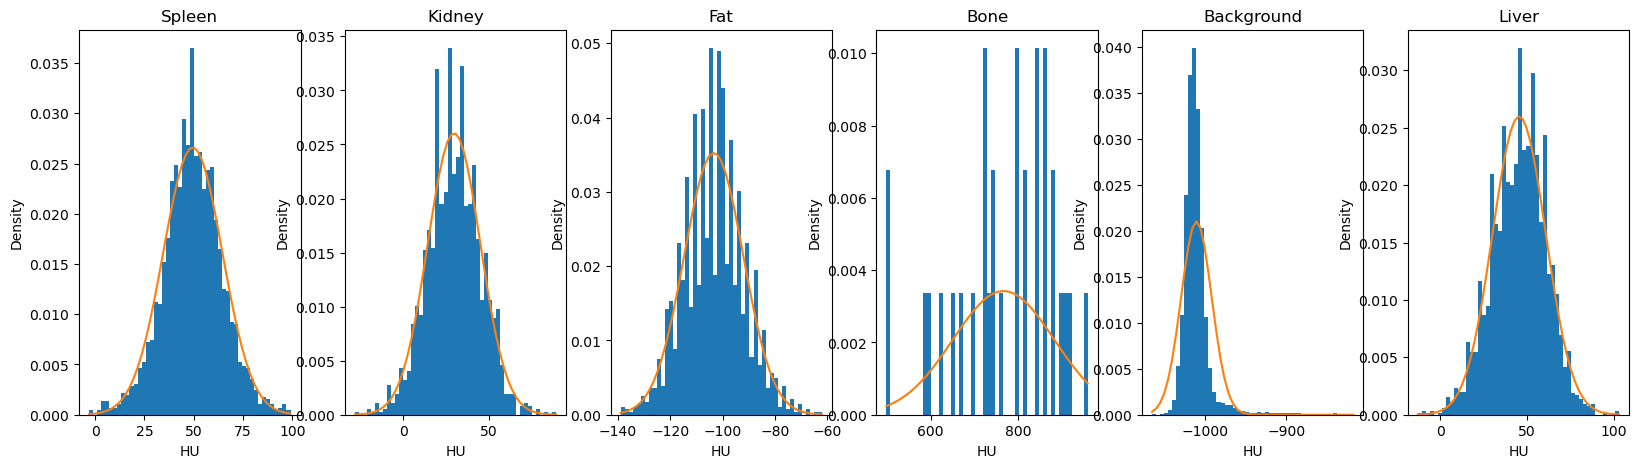

In [9]:
# Exercise 4 
# read ROIs 
kidney_roi = io.imread(in_dir + 'KidneyROI.png')
fat_roi = io.imread(in_dir + 'FatROI.png')
bone_roi = io.imread(in_dir + 'BoneROI.png')
background_roi = io.imread(in_dir + 'BackgroundROI.png')
liver_roi = io.imread(in_dir + "LiverROI.png")

# get values
kidney_mask, fat_mask, bone_mask, background_mask, liver_mask = kidney_roi > 0, fat_roi > 0, bone_roi > 0, background_roi > 0, liver_roi > 0 
kidney_values, fat_values, bone_values, background_values, liver_values = img[kidney_mask], img[fat_mask], img[bone_mask], img[background_mask], img[liver_mask]

# compute mean and std 
mu_kidney, mu_fat, mu_bone, mu_background, mu_liver = np.mean(kidney_values), np.mean(fat_values), np.mean(bone_values), np.mean(background_values), np.mean(liver_values)
std_kidney, std_fat, std_bone, std_background, std_liver = np.std(kidney_values), np.std(fat_values), np.std(bone_values), np.std(background_values), np.std(liver_values)

# gather in array for easy plotting 
means = np.array([mu_spleen, mu_kidney, mu_fat, mu_bone, mu_background, mu_liver])
stds = np.array([std_spleen, std_kidney, std_fat, std_bone, std_background, std_liver])
titles = np.array(["Spleen", "Kidney", "Fat", "Bone", "Background", "Liver"])
values = np.array([spleen_values, kidney_values, fat_values, bone_values, background_values, liver_values])
ns, bins, patches = [], [], []
fig, ax = plt.subplots(1, 6, figsize = (20, 5))
for i in range(6): 
    n, bin, patch = ax[i].hist(values[i].ravel(), bins = 50, density=True)
    ns.append(n), bins.append(bin), patches.append(patch)
    ax[i].plot(bin, norm.pdf(bin, means[i], stds[i]))
    ax[i].set_xlabel("HU")
    ax[i].set_ylabel("Density")
    ax[i].set_title(titles[i])
plt.show()



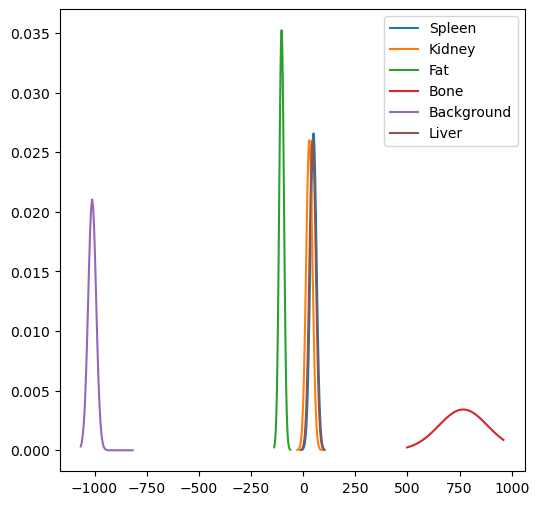

In [10]:
# Exercise 5
plt.figure(figsize = (6, 6))
for i in range(len(bins)): 
    plt.plot(bins[i], norm.pdf(bins[i], means[i], stds[i]), label = titles[i])
plt.legend()
plt.show()

# kidney and spleen are difficult to distinguish 

### Minimum distance pixel classification

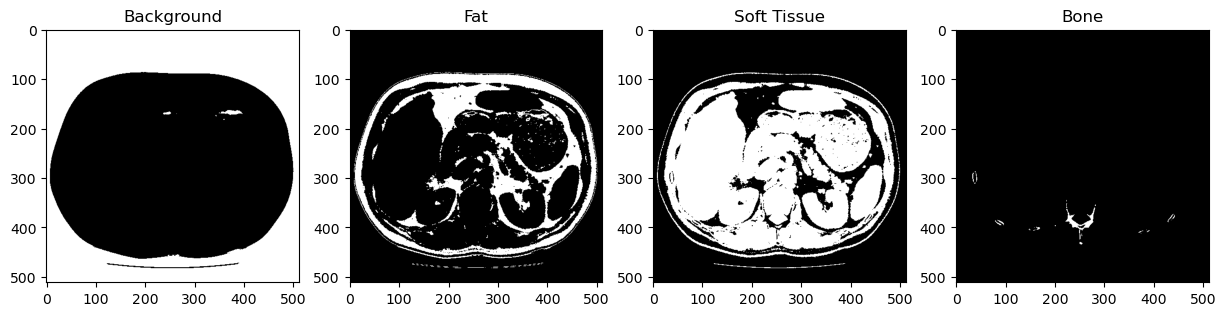

In [11]:
# Exercise 7
# compute mean ogf soft tissue class 
soft_tissue_values = np.append(kidney_values, spleen_values)
soft_tissue_values = np.append(soft_tissue_values, liver_values)
(mu_soft, std_soft) = norm.fit(soft_tissue_values)

# compute thresholds 
t_background = -200
t_fat_soft = (mu_fat + mu_soft) / 2.0
t_soft_bone = (mu_soft + mu_bone) / 2.0 

# compute bimary images 
background_img = img <= t_background 
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone 

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()


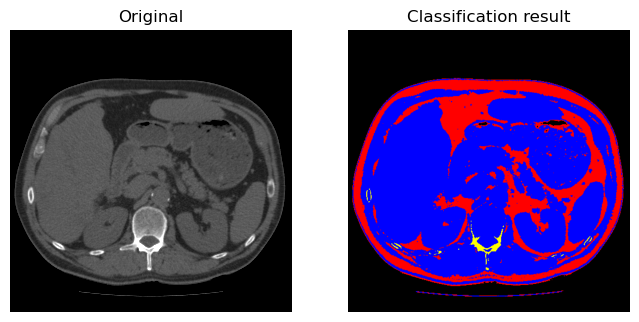

In [12]:
# Exercise 8 
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

### Parametric Pixel Classification

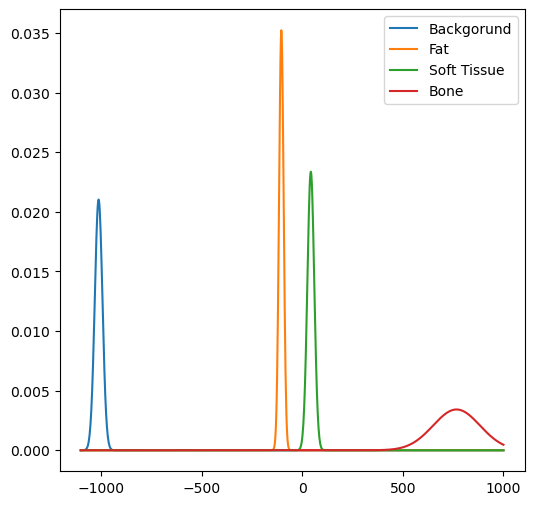

In [13]:
# Exercise 9 
means = np.array([mu_background, mu_fat, mu_soft, mu_bone])
stds = np.array([std_background, std_fat, std_soft, std_bone])
titles = np.array(["Backgorund", "Fat", "Soft Tissue", "Bone"])
x = np.linspace(-1100, 1000, 1000)
plt.figure(figsize = (6, 6))
for i in range(4): 
    plt.plot(x, norm.pdf(x, means[i], stds[i]), label = titles[i])
plt.legend()
plt.show()


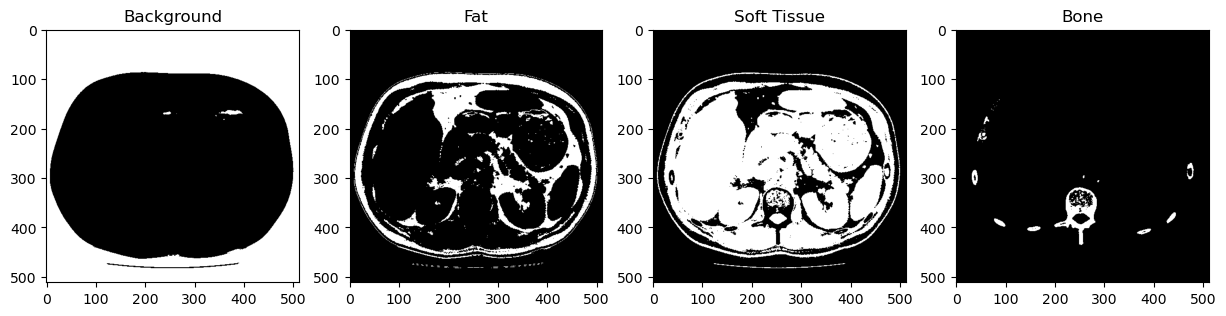

In [14]:
# Exercise 10
# Found by inspecting the plot and seeing where the Gaussian crosses
# for test_value in range(-50, -30):
#     if norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_soft, std_soft):
#         print(f"For value {test_value} the class is fat")
#     else:
#         print(f"For value {test_value} the class is soft tissue")

t_background = -200
t_fat_soft = -45 
t_soft_bone = 141

# compute bimary images 
background_img = img <= t_background 
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone 

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

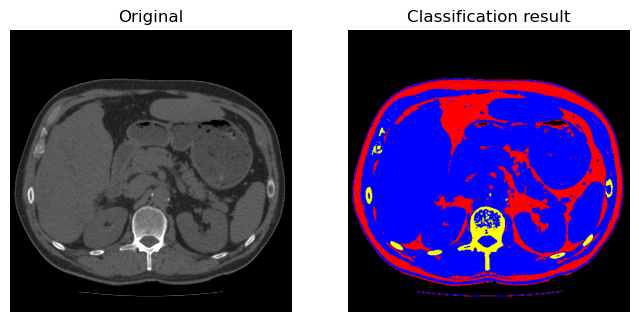

In [15]:
# exercise 11 
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

### Object segmentation 

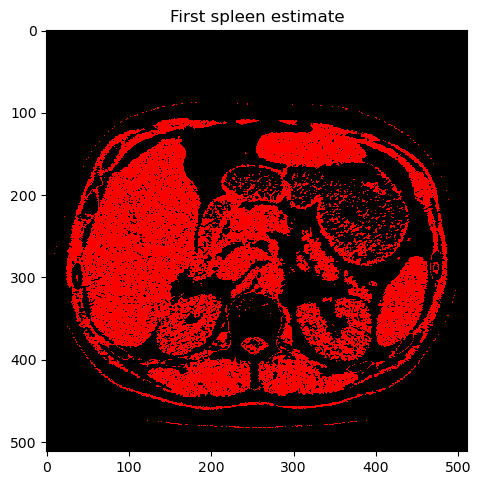

In [16]:
# Exercise 11 
t_1 = 20
t_2 = 80 
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

In [17]:
# Exercise 12
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(4)
opened = binary_opening(closed, footprint)

label_img = measure.label(opened)

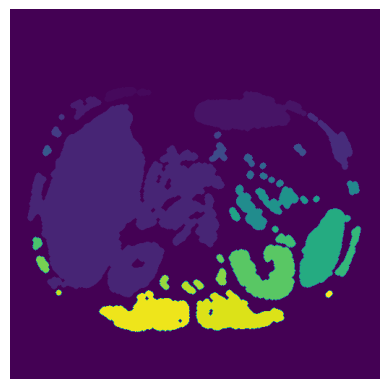

In [18]:
# Exercise 13
plt.imshow(label_img)
plt.axis("off")
plt.show()

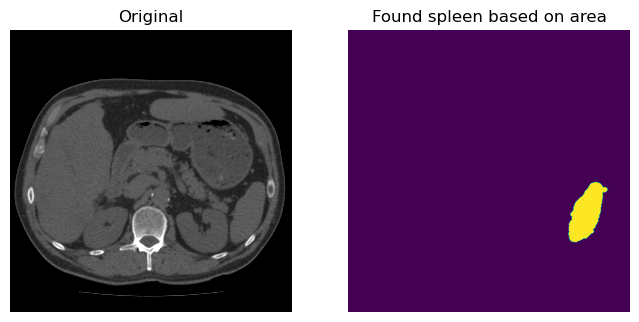

In [19]:
# Exercise 14
min_area = 2000
max_area = 10000 
min_ecc = 0.90
max_perimeter = 350 

# Create a copy of the label_img
label_img_filter = label_img.copy()
region_props = measure.regionprops(label_img)
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

In [20]:
# Exercise 15 
def spleen_finder(ct_image, max_area = 10000, min_area = 1000, min_ecc = 0.9, max_perimeter = 350, min_perimeter = 250): 
    # thresholding 
    t_1, t_2 = 20, 80
    spleen_estimate = (ct_image > t_1) & (ct_image < t_2)
    
    #  morphological operations 
    fp1, fp2 = disk(2), disk(4)
    closed = binary_closing(spleen_estimate, fp1)
    opened = binary_opening(closed, fp2)

    # image to label
    label_img = measure.label(opened)
    label_img_filter = label_img.copy()

    region_props = measure.regionprops(label_img)
    for region in region_props:
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter or region.perimeter < min_perimeter:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    return label_img_filter > 0
    



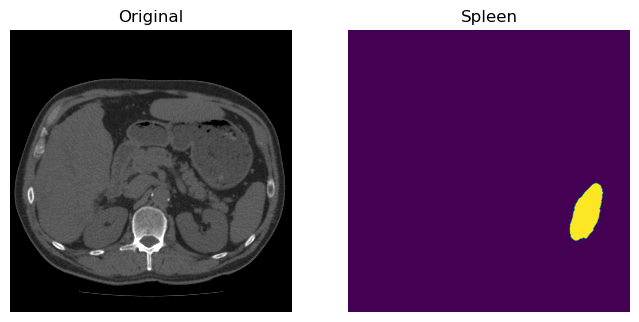

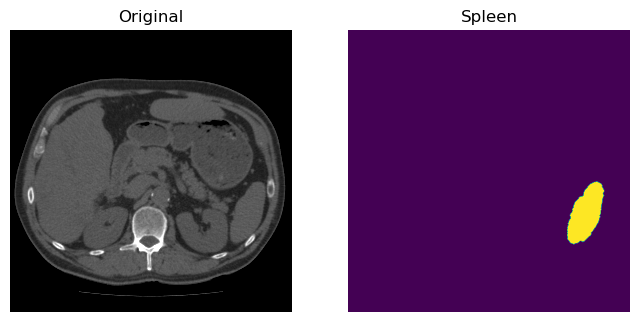

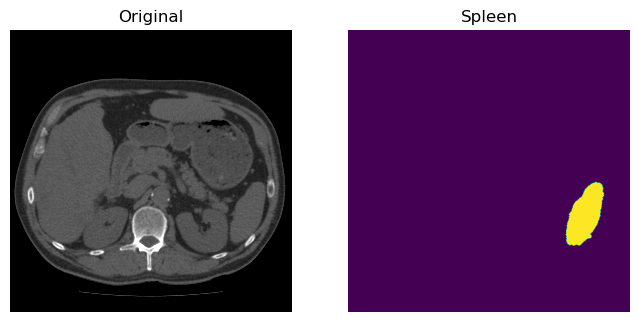

In [21]:
# Exercise 16 
val1, val2, val3 = io.imread("data_ex6/Validation1.dcm"), io.imread("data_ex6/Validation2.dcm"), io.imread("data_ex6/Validation3.dcm")
show_comparison(img, spleen_finder(val1), 'Spleen')
show_comparison(img, spleen_finder(val2), 'Spleen')
show_comparison(img, spleen_finder(val3), 'Spleen')


In [22]:
# Exercise 17
# Get predictions 
pred1 = spleen_finder(val1)
pred2 = spleen_finder(val2)
pred3 = spleen_finder(val3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Validation1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Validation2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Validation3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")

Score 1 = 0.9558359621451105, Score 2 = 0.9471671530643051, Score 3 = 0.9715459078908771


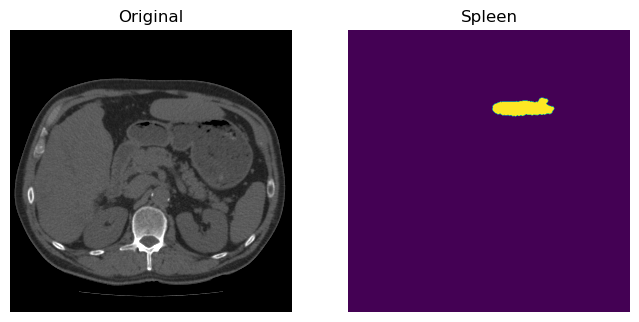

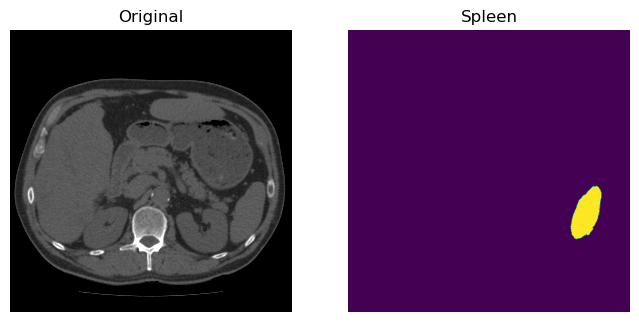

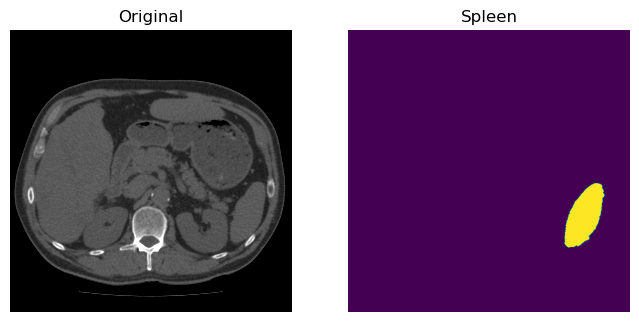

In [23]:
# Exercise 18 
test1, test2, test3 = io.imread("data_ex6/Test1.dcm"), io.imread("data_ex6/Test2.dcm"), io.imread("data_ex6/Test3.dcm")
show_comparison(img, spleen_finder(test1), 'Spleen')
show_comparison(img, spleen_finder(test2), 'Spleen')
show_comparison(img, spleen_finder(test3), 'Spleen')

In [24]:
# Exercise 17
# Get predictions 
pred1 = spleen_finder(test1)
pred2 = spleen_finder(test2)
pred3 = spleen_finder(test3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Test1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Test2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Test3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")

Score 1 = 0.0, Score 2 = 0.779185520361991, Score 3 = 0.967035025285634
